# Inspecting Features of Flights within Airspace

European FIRs

In [1]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import pandas as pd

import os
import sys

# Get the current directory
current_dir = os.path.dirname(os.path.abspath('__file__'))

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Add the parent directory to sys.path
sys.path.append(parent_dir)
sys.path.append(os.path.join(parent_dir, 'turning_scripts'))

from data_preambles import dtypes_no_id, col_names, csv_to_exclude, catalog_col_names
from path_prefix import PATH_PREFIX



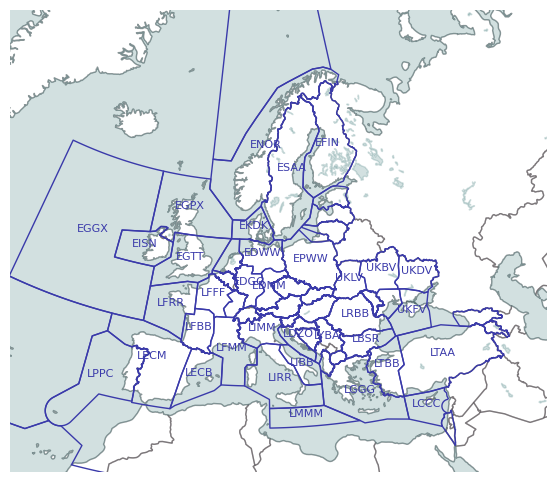

In [2]:
import matplotlib.pyplot as plt

from cartes.crs import LambertConformal
from cartes.utils.features import countries, lakes, ocean
from traffic.data import eurofirs

fig, ax = plt.subplots(
    figsize=(8, 6),
    subplot_kw=dict(projection=LambertConformal(10, 45)),
)

ax.set_extent((-20, 45, 25, 75))

ax.add_feature(countries(scale="50m"))
ax.add_feature(lakes(scale="50m"))
ax.add_feature(ocean(scale="50m"))

ax.spines['geo'].set_visible(False)

for fir in eurofirs:
    fir.plot(ax, edgecolor="#3a3aaa")
    if fir.designator not in ["ENOB", "LPPO", "GCCC"] and fir.area > 1e11:
        fir.annotate(
            ax,
            s=fir.designator,
            ha="center",
            color="#3a3aaa",
            fontsize=8,
        )

Now we load up some flight segments and compute some features related to the airspace

In [3]:
import pandas as pd 

df = pd.read_csv(f'{PATH_PREFIX}/data/hourly/1718193600.csv')
# df columns: 'id', 'time', 'from_lat', 'from_lon', 'to_lat', 'to_lon'
df.head()

,id,from_time,to_time,from_lat,from_lon,to_lat,to_lon,from_alt,to_alt,from_speed,to_speed
0,3985a4AFR49XW,1.718196e+09,1.718197e+09,42.603012,8.759974,42.674423,8.637064,1211.58,2301.24,0.213525,0.124869
1,3985a4AFR49XW,1.718197e+09,1.718197e+09,42.674423,8.637064,43.495010,7.544605,2301.24,8770.62,0.124869,0.000000
2,4ac9c6BLX378,1.718194e+09,1.718194e+09,56.610947,17.525597,56.743149,17.546110,10607.04,10607.04,0.245892,0.245678
3,4ac9c6BLX378,1.718194e+09,1.718195e+09,56.743149,17.546110,58.836639,17.904259,10607.04,5753.10,0.245678,0.157164
4,4ac9c6BLX378,1.718195e+09,1.718195e+09,58.836639,17.904259,59.137115,18.156281,5753.10,4587.24,0.157164,0.141790


In [4]:
def get_fir_polygon(fir_name):
    """
    Get FIR polygon from traffic.data eurofirs.
    
    Args:
        fir_name (str): FIR identifier (e.g., 'EGTT')
    
    Returns:
        shapely.geometry.Polygon: Polygon representing the FIR boundary
    """
    # Get FIR data from eurofirs
    fir = eurofirs.query(f"designator == '{fir_name}'")
    return fir.data.iloc[0].geometry

def filter_segments_by_fir(segments_df, fir_name):
    """
    Filter segments that have at least one endpoint within the specified FIR.
    
    Args:
        segments_df (pd.DataFrame): DataFrame containing segments with columns 
            [from_lat, from_lon, to_lat, to_lon]
        fir_name (str): FIR identifier (e.g., 'EGTT')
    
    Returns:
        pd.DataFrame: Filtered DataFrame containing only segments with points inside the FIR
    """
    from shapely.geometry import Point
    from shapely.prepared import prep
    
    # Get FIR polygon from your FIR data source
    fir_polygon = get_fir_polygon(fir_name)  # You'll need to implement this
    prepared_polygon = prep(fir_polygon)  # Optimize for repeated contains checks
    
    def point_in_fir(lat, lon):
        point = Point(lon, lat)  # Note: Shapely uses (x,y) order (lon,lat)
        return prepared_polygon.contains(point)
    
    # Create mask for segments where either endpoint is inside the FIR
    mask = (
        segments_df.apply(lambda row: (
            point_in_fir(row['from_lat'], row['from_lon']) or 
            point_in_fir(row['to_lat'], row['to_lon'])
        ), axis=1)
    )
    
    # Return filtered DataFrame
    return segments_df[mask]

In [5]:
def count_segments_within_fir(segments_df, fir_name):
    """
    Count segments that have both endpoints within the specified FIR.
    
    Args:
        segments_df (pd.DataFrame): DataFrame containing segments with columns 
            [from_lat, from_lon, to_lat, to_lon]
        fir_name (str): FIR identifier (e.g., 'EGTT')
    
    Returns:
        int: Number of segments entirely within the FIR
    """
    from shapely.geometry import Point
    from shapely.prepared import prep
    
    # Get FIR polygon from your FIR data source
    fir_polygon = get_fir_polygon(fir_name)
    prepared_polygon = prep(fir_polygon)  # Optimize for repeated contains checks
    
    def point_in_fir(lat, lon):
        point = Point(lon, lat)  # Note: Shapely uses (x,y) order (lon,lat)
        return prepared_polygon.contains(point)
    
    # Create mask for segments where both endpoints are inside the FIR
    mask = (
        segments_df.apply(lambda row: (
            point_in_fir(row['from_lat'], row['from_lon']) and 
            point_in_fir(row['to_lat'], row['to_lon'])
        ), axis=1)
    )
    
    # Return filtered DataFrame with segments entirely within FIR
    return segments_df[mask]


In [6]:
# Visualize one airspace
fir_name = 'LFMM'
filtered_df = filter_segments_by_fir(df, fir_name)
filtered_df.head()

print(f'During one hour:')
print(f"- Number of segments in {fir_name}: {len(filtered_df)}")
print(f"- Number of unique flights in {fir_name}: {filtered_df['id'].nunique()}")
# Example usage
fir_name = 'LFMM'
segments_within = count_segments_within_fir(df, fir_name)
print(f"- Number of segments entirely within {fir_name}: {len(segments_within)}")
print(f"- Number of unique flights entirely within {fir_name}: {segments_within['id'].nunique()}")


During one hour:
- Number of segments in LFMM: 1291
- Number of unique flights in LFMM: 407
- Number of segments entirely within LFMM: 867
- Number of unique flights entirely within LFMM: 321


In [7]:
# Load the airports from airports.csv
df_airports = pd.read_csv(f'{PATH_PREFIX}/data/airports.csv')
df_airports.columns # ['iata', 'latitude', 'longitude']
# Reduce the dataframe to airports inside the FIR
# Create points for each airport
from shapely.geometry import Point
from shapely.prepared import prep

# Get FIR polygon and prepare it for efficient contains checks
fir_polygon = get_fir_polygon(fir_name)
prepared_polygon = prep(fir_polygon)

# Filter airports inside FIR
airports_in_fir = df_airports[
    df_airports.apply(lambda row: prepared_polygon.contains(
        Point(row['longitude'], row['latitude'])
    ), axis=1)
]

print(f"Number of airports in {fir_name}: {len(airports_in_fir)}")
airports_in_fir.head()


Number of airports in LFMM: 41


,country_code,region_name,iata,icao,airport,latitude,longitude
2955,FR,Auvergne-Rhone-Alpes,AHZ,LFHU,Alpe d'Huez Airport,45.0883,6.08472
2957,FR,Auvergne-Rhone-Alpes,CFE,LFLC,Clermont-Ferrand Auvergne Airport,45.7867,3.16917
2958,FR,Auvergne-Rhone-Alpes,CMF,LFLB,Chambery-Savoie Airport,45.6381,5.88023
2959,FR,Auvergne-Rhone-Alpes,CVF,LFLJ,Courchevel Altiport,45.3967,6.63472
2960,FR,Auvergne-Rhone-Alpes,EBU,LFMH,Saint-Etienne-Boutheon Airport,45.5406,4.29639


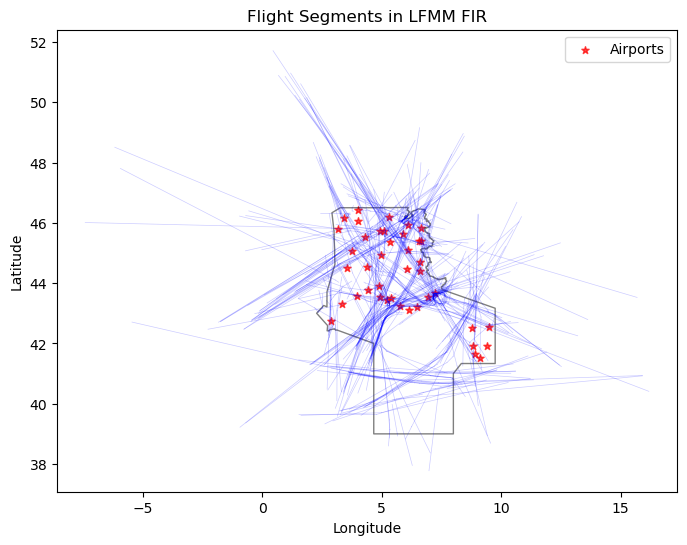

In [8]:
# Plot the FIR and the filtered segments
import matplotlib.pyplot as plt

# Get FIR polygon
fir_polygon = get_fir_polygon(fir_name)

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot FIR polygon
x, y = fir_polygon.exterior.xy
ax.plot(x, y, 'k-', alpha=0.5, linewidth=1)

# Plot segments
# Sample 100 random segments
# sampled_df = filtered_df.sample(n=min(100, len(filtered_df)), random_state=42)
sampled_df = filtered_df
for _, row in sampled_df.iterrows():
    ax.plot([row['from_lon'], row['to_lon']], 
            [row['from_lat'], row['to_lat']], 
            'b-', alpha=0.2, linewidth=0.5)
    # # Plot from points in green and to points in red
    # ax.scatter(row['from_lon'], row['from_lat'], c='green', s=10, alpha=0.3)
    # ax.scatter(row['to_lon'], row['to_lat'], c='red', s=10, alpha=0.3)

# Plot airports with stars
ax.scatter(airports_in_fir['longitude'], airports_in_fir['latitude'], 
          marker='*', c='red', s=30, alpha=0.7, label='Airports')
ax.legend()


# Set axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Flight Segments in {fir_name} FIR')

plt.show()


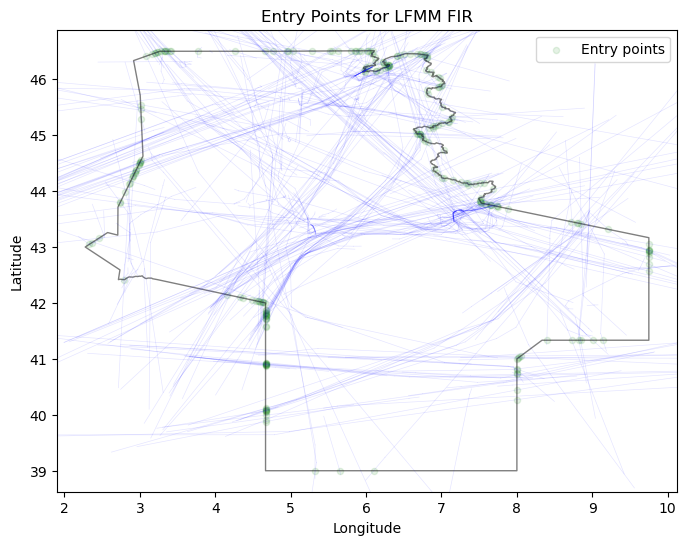

Number of entry points: 232


In [9]:
from shapely.geometry import LineString, Point
import numpy as np

def find_intersection_points(df, fir_polygon):
    entry_points = []
    exit_points = []
    
    for _, row in df.iterrows():
        # Create line segment from flight path
        line = LineString([(row['from_lon'], row['from_lat']), 
                         (row['to_lon'], row['to_lat'])])
        
        # If line intersects with FIR boundary
        if line.intersects(fir_polygon.boundary):
            # Get intersection point(s)
            intersection = line.intersection(fir_polygon.boundary)
            
            # Handle both single point and multiple points cases
            if intersection.geom_type == 'Point':
                points = [intersection]
            else:  # MultiPoint
                points = list(intersection.geoms)
            
            # Sort points by distance from start of segment
            points.sort(key=lambda p: LineString([(row['from_lon'], row['from_lat']), (p.x, p.y)]).length)
            
            # First point is entry, last point is exit
            if len(points) >= 1:
                if fir_polygon.contains(Point(row['from_lon'], row['from_lat'])):
                    # Flight starts inside FIR
                    exit_points.append((points[-1].x, points[-1].y))
                else:
                    # Flight starts outside FIR
                    entry_points.append((points[0].x, points[0].y))
                    
                if len(points) > 1:
                    if fir_polygon.contains(Point(row['from_lon'], row['from_lat'])):
                        # Flight starts inside FIR
                        entry_points.append((points[0].x, points[0].y))
                    else:
                        # Flight starts outside FIR
                        exit_points.append((points[-1].x, points[-1].y))

    return np.array(entry_points), np.array(exit_points)

# Get entry and exit points
entry_points, exit_points = find_intersection_points(filtered_df, fir_polygon)

# Plot the results
fig, ax = plt.subplots(figsize=(8, 6))

# Plot FIR polygon
x, y = fir_polygon.exterior.xy
ax.plot(x, y, 'k-', alpha=0.5, linewidth=1)

# Plot segments (optional, can be commented out if too cluttered)
for _, row in filtered_df.iterrows():
    ax.plot([row['from_lon'], row['to_lon']], 
            [row['from_lat'], row['to_lat']], 
            'b-', alpha=0.1, linewidth=0.5)

# Plot entry points in green and exit points in red
if len(entry_points) > 0:
    ax.scatter(entry_points[:, 0], entry_points[:, 1], 
              c='green', s=20, alpha=0.1, label='Entry points')
    
# Get bounds of FIR polygon
bounds = fir_polygon.bounds  # Returns (minx, miny, maxx, maxy)
# Add 5% margin to the bounds
margin_x = (bounds[2] - bounds[0]) * 0.05
margin_y = (bounds[3] - bounds[1]) * 0.05
ax.set_xlim(bounds[0] - margin_x, bounds[2] + margin_x)
ax.set_ylim(bounds[1] - margin_y, bounds[3] + margin_y)


ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Entry Points for {fir_name} FIR')
ax.legend()

plt.show()

print(f"Number of entry points: {len(entry_points)}")


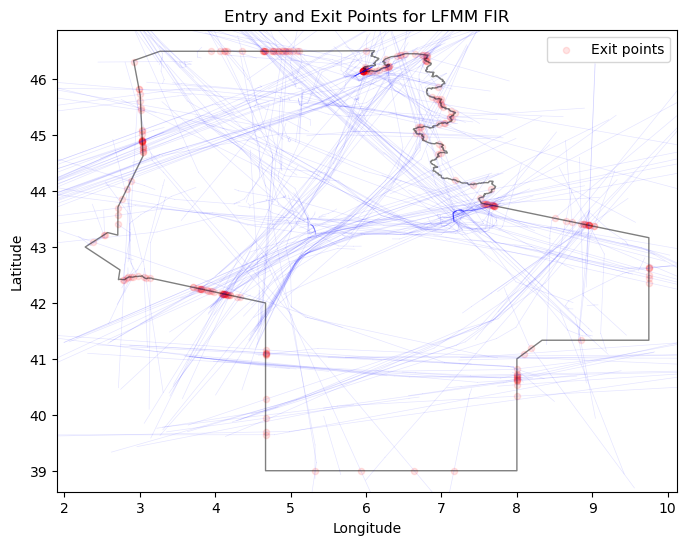

Number of exit points: 252


In [10]:
from shapely.geometry import LineString, Point
import numpy as np

def find_intersection_points(df, fir_polygon):
    entry_points = []
    exit_points = []
    
    for _, row in df.iterrows():
        # Create line segment from flight path
        line = LineString([(row['from_lon'], row['from_lat']), 
                         (row['to_lon'], row['to_lat'])])
        
        # If line intersects with FIR boundary
        if line.intersects(fir_polygon.boundary):
            # Get intersection point(s)
            intersection = line.intersection(fir_polygon.boundary)
            
            # Handle both single point and multiple points cases
            if intersection.geom_type == 'Point':
                points = [intersection]
            else:  # MultiPoint
                points = list(intersection.geoms)
            
            # Sort points by distance from start of segment
            points.sort(key=lambda p: LineString([(row['from_lon'], row['from_lat']), (p.x, p.y)]).length)
            
            # First point is entry, last point is exit
            if len(points) >= 1:
                if fir_polygon.contains(Point(row['from_lon'], row['from_lat'])):
                    # Flight starts inside FIR
                    exit_points.append((points[-1].x, points[-1].y))
                else:
                    # Flight starts outside FIR
                    entry_points.append((points[0].x, points[0].y))
                    
                if len(points) > 1:
                    if fir_polygon.contains(Point(row['from_lon'], row['from_lat'])):
                        # Flight starts inside FIR
                        entry_points.append((points[0].x, points[0].y))
                    else:
                        # Flight starts outside FIR
                        exit_points.append((points[-1].x, points[-1].y))

    return np.array(entry_points), np.array(exit_points)

# Get entry and exit points
entry_points, exit_points = find_intersection_points(filtered_df, fir_polygon)

# Plot the results
fig, ax = plt.subplots(figsize=(8, 6))

# Plot FIR polygon
x, y = fir_polygon.exterior.xy
ax.plot(x, y, 'k-', alpha=0.5, linewidth=1)

# Plot segments (optional, can be commented out if too cluttered)
for _, row in filtered_df.iterrows():
    ax.plot([row['from_lon'], row['to_lon']], 
            [row['from_lat'], row['to_lat']], 
            'b-', alpha=0.1, linewidth=0.5)

# Plot entry points in green and exit points in red
if len(entry_points) > 0:
    ax.scatter(exit_points[:, 0], exit_points[:, 1], 
              c='red', s=20, alpha=0.1, label='Exit points')
    
# Get bounds of FIR polygon
bounds = fir_polygon.bounds  # Returns (minx, miny, maxx, maxy)
# Add 5% margin to the bounds
margin_x = (bounds[2] - bounds[0]) * 0.05
margin_y = (bounds[3] - bounds[1]) * 0.05
ax.set_xlim(bounds[0] - margin_x, bounds[2] + margin_x)
ax.set_ylim(bounds[1] - margin_y, bounds[3] + margin_y)


ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Entry and Exit Points for {fir_name} FIR')
ax.legend()

plt.show()

print(f"Number of exit points: {len(exit_points)}")


In [11]:
# # Plot one flight
# df_id = filtered_df['id'].unique()[23]
# df_id_df = filtered_df[filtered_df['id'] == df_id]
# # Sort the flight segments by time
# df_id_df = df_id_df.sort_values('time')



# df_id_df.head()

In [12]:
# # Create a new figure
# fig, ax = plt.subplots(figsize=(8, 6))

# # Plot FIR polygon as background reference
# x, y = fir_polygon.exterior.xy
# ax.plot(x, y, 'k-', alpha=0.5, linewidth=1)

# # Plot the trajectory
# ax.plot(df_id_df['from_lon'].tolist() + [df_id_df['to_lon'].iloc[-1]], 
#         df_id_df['from_lat'].tolist() + [df_id_df['to_lat'].iloc[-1]], 
#         'b-', linewidth=2, label='Flight path')

# # Add Marseille Airport coordinates
# marseille_coords = (5.2145, 43.4365)  # (lon, lat)
# ax.scatter(marseille_coords[0], marseille_coords[1], 
#           c='red', marker='^', s=100, label='Marseille Airport')


# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# ax.set_title(f'Flight Trajectory for {df_id}')
# ax.legend()

# plt.show()


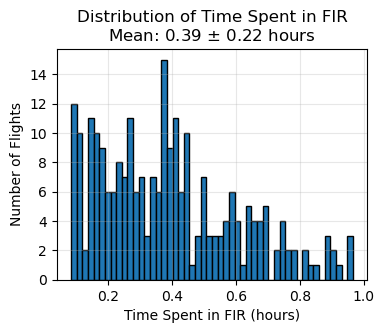

In [13]:
# Calculate time spent in FIR for each flight
time_in_fir = filtered_df.groupby('id').agg({'from_time': lambda x: x.max() - x.min()})
time_in_fir = time_in_fir[time_in_fir['from_time'] >= 300]  # Filter for at least 5 minutes (300 seconds)

# Create histogram
plt.figure(figsize=(4, 3))
plt.hist(time_in_fir['from_time']/3600, bins=50, edgecolor='black')  # Convert to hours
plt.xlabel('Time Spent in FIR (hours)')
plt.ylabel('Number of Flights')
plt.title(f'Distribution of Time Spent in FIR\nMean: {time_in_fir["from_time"].mean()/3600:.2f} $\pm$ {time_in_fir["from_time"].std()/3600:.2f} hours')
plt.grid(True, alpha=0.3)
plt.show()


In [33]:
filtered_df.columns # ['id', 'time', 'from_lat', 'from_lon', 'to_lat', 'to_lon']
# Function to find intersection point of two line segments
def line_intersection(x1, y1, x2, y2, x3, y3, x4, y4,
                      z1, z2, t1, t2, t3, t4, time_threshold=60, **kwargs): 
    # x1,y1,x2,y2 is first segment with times t1,t2
    # x3,y3,x4,y4 is second segment with times t3,t4
    # time_threshold in seconds (default 5 minutes)

    # Returns None if kwargs['id1'] == kwargs['id2']
    if kwargs['id1'] == kwargs['id2']:
        return None
    
    # Returns None if abs(z1-z2) > 1000
    if abs(z1-z2) > 1000:
        return None
    
    # Returns None if lines don't intersect
    denominator = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if denominator == 0:
        return None
    
    t = ((x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)) / denominator
    u = -((x1 - x2) * (y1 - y3) - (y1 - y2) * (x1 - x3)) / denominator
    
    # Check if intersection occurs within both line segments
    if 0 <= t <= 1 and 0 <= u <= 1:
        x = x1 + t * (x2 - x1)
        y = y1 + t * (y2 - y1)
        
        # Calculate times at crossing
        t_at_crossing1 = t1 + t * (t2 - t1)  # Linear interpolation of time for first aircraft
        t_at_crossing2 = t3 + u * (t4 - t3)  # Linear interpolation of time for second aircraft
        
        # Check if times are within threshold
        if abs(t_at_crossing1 - t_at_crossing2) <= time_threshold:
            print(kwargs['id1'], z1, kwargs['id2'], z2, f'{t_at_crossing2 - t_at_crossing1:.2f}s')
            return (x, y, t_at_crossing1, t_at_crossing2, z1, z2)
            
    return None

# Sample 1000 segments randomly
n_samples = 1000
sampled_segments = filtered_df.sample(n=min(n_samples, len(filtered_df)))

# Find all intersections
intersections = []
for i, seg1 in sampled_segments.iterrows():
    for j, seg2 in sampled_segments.iterrows():
        if i < j:  # Avoid checking same pair twice
            intersection = line_intersection(
                seg1['from_lon'], seg1['from_lat'], 
                seg1['to_lon'], seg1['to_lat'],
                seg2['from_lon'], seg2['from_lat'], 
                seg2['to_lon'], seg2['to_lat'],
                seg1['from_alt'], seg2['from_alt'],
                seg1['from_time'], seg1['to_time'],
                seg2['from_time'], seg2['to_time'],
                id1=seg1['id'], id2=seg2['id']
            )
            if intersection:
                intersections.append((seg1['id'], seg2['id'], intersection))

3e1c91BFX43T   12108.18 4d2406EWG5UV   11498.580000000002 30.16s
3452c9VLG38AU  11201.4 4402acEJU17VH  11772.9 58.82s
4ca76fEIN5TJ   9418.32 3c49ccEWG14M   9357.36 -37.80s
0200fbRAM947B  11506.2 008febTVS2060  10896.6 -34.73s
0200fbRAM947B  11506.2 ab0a9dDAL9887  11597.64 21.11s
39b083ARL915   11521.44 392af0AFR1285  11224.26 -30.00s
39b083ARL915   11521.44 48af0cLOT6394  11262.36 -9.93s
4d225fRYR93NF  9357.36 4ca303RYR58WX  9060.18 3.60s
3c0ac6CFG1TK   11163.3 346614VOE6FV   11803.38 -42.25s
4b1618SWR2177  11163.3 aaf828AAL759   11369.04 12.81s
49410cNJE477Y  12763.500000000002 4077d4VIR412W  12557.76 53.86s
02a196TAR514   11940.54 4d2211RYR61FX  11894.820000000002 2.17s
44ce72BEL8RN   10523.22 3c6746DLH33V   9608.82 48.93s
4b1a28EZS46NQ  7635.240000000001 4cae53RYR89BB  8077.200000000001 -55.31s
3c66b9OCN6VC   11887.2 342582VLG412J  10904.22 5.39s
4aca06NSZ2KT   11414.76 440237EJU52HG  11795.76 -12.72s
4d2251RYR2408  11894.820000000002 440132EJU75CH  11231.88 22.54s
3c4b45EWG5CL   11

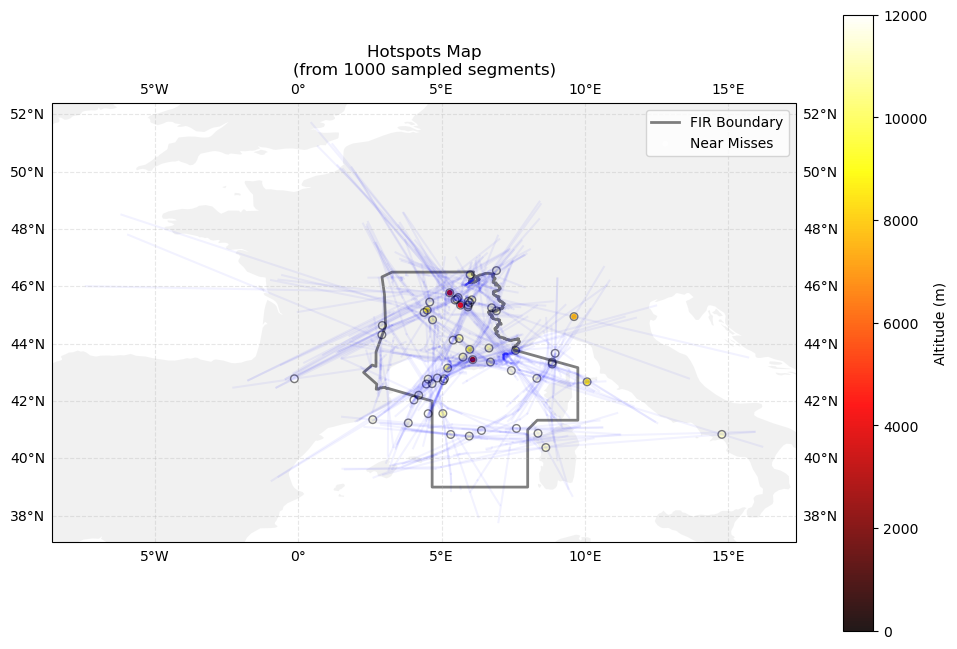

Found 56 intersection points


In [44]:
# Create plot with cartopy projection
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, ax = plt.subplots(figsize=(12, 8), 
                       subplot_kw={'projection': ccrs.PlateCarree()})

# Add land features
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
# ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
# ax.add_feature(cfeature.BORDERS, linewidth=0.5)
# ax.add_feature(cfeature.LAKES, alpha=0.5)
# ax.add_feature(cfeature.RIVERS, linewidth=0.5)

# Plot FIR polygon
x, y = fir_polygon.exterior.xy
ax.plot(x, y, 'k-', alpha=0.5, linewidth=2, label='FIR Boundary', 
        transform=ccrs.PlateCarree())

# Plot sampled segments
for _, seg in sampled_segments.iterrows():
    ax.plot([seg['from_lon'], seg['to_lon']], 
            [seg['from_lat'], seg['to_lat']], 
            'b-', alpha=0.05, transform=ccrs.PlateCarree())

# Plot intersection points
if intersections:
    intersection_points = [x[2] for x in intersections]
    intersection_points = np.array(intersection_points)
    scatter = ax.scatter(intersection_points[:, 0], intersection_points[:, 1],
              c=intersection_points[:, 4], s=10, alpha=0.9, label='Near Misses',
              cmap='hot', transform=ccrs.PlateCarree(),
              vmin=0, vmax=12000)  # Set fixed altitude range 0-12km
    # Add outline circles around the intersection points
    ax.scatter(intersection_points[:, 0], intersection_points[:, 1],
              facecolors='none', edgecolors='black', s=30, alpha=0.5,
              transform=ccrs.PlateCarree())
    plt.colorbar(scatter, label='Altitude (m)')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude') 
ax.set_title(f'Hotspots Map\n(from {len(sampled_segments)} sampled segments)')
ax.gridlines(draw_labels=True, alpha=0.3, linestyle='--')
ax.legend()

plt.show()

print(f"Found {len(intersections)} intersection points")


In [45]:
intersections[6]

('39b083ARL915  ',
 '48af0cLOT6394 ',
 (8.319999282026645,
  42.7944820936307,
  1718194182.6741886,
  1718194172.7443829,
  11521.44,
  11262.36))

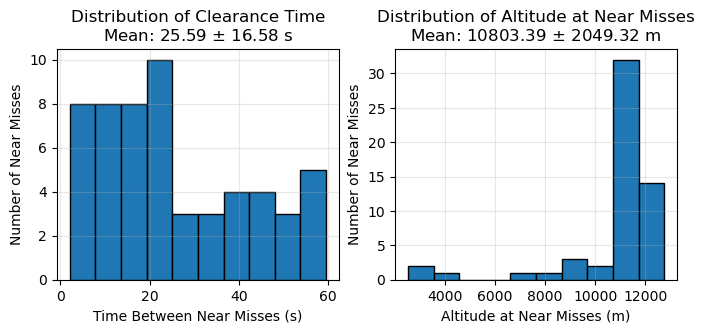

In [50]:
# Distribution of time between near misses
clearance_time_for_nearmisses = [x[2] for x in intersections]
clearance_time_for_nearmisses = [np.abs(x[3] - x[2]) for x in clearance_time_for_nearmisses]
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.hist(clearance_time_for_nearmisses, bins=10, edgecolor='black')
plt.xlabel('Time Between Near Misses (s)')
plt.ylabel('Number of Near Misses')
plt.title(f'Distribution of Clearance Time\nMean: {np.mean(clearance_time_for_nearmisses):.2f} $\pm$ {np.std(clearance_time_for_nearmisses):.2f} s')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
alt_at_near_misses = [x[2] for x in intersections]
alt_at_near_misses = [x[4] for x in alt_at_near_misses]
plt.hist(alt_at_near_misses, bins=10, edgecolor='black')
plt.xlabel('Altitude at Near Misses (m)')
plt.ylabel('Number of Near Misses')
plt.title(f'Distribution of Altitude at Near Misses\nMean: {np.mean(alt_at_near_misses):.2f} $\pm$ {np.std(alt_at_near_misses):.2f} m')
plt.grid(True, alpha=0.3)

plt.show()


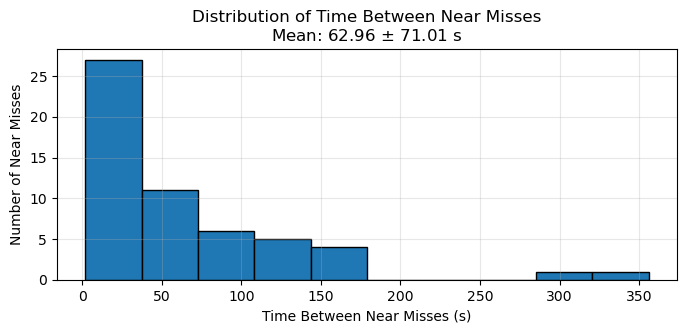

In [52]:
time_between_nearmisses = [x[2] for x in intersections]
time_between_nearmisses = np.array([x[3] for x in time_between_nearmisses])
# Sort the time_between_nearmisses
time_between_nearmisses = np.sort(time_between_nearmisses)
# Get difference between consecutive elements
time_between_nearmisses = np.diff(time_between_nearmisses)

plt.figure(figsize=(8, 3))
plt.hist(time_between_nearmisses, bins=10, edgecolor='black')
plt.xlabel('Time Between Near Misses (s)')
plt.ylabel('Number of Near Misses')
plt.title(f'Distribution of Time Between Near Misses\nMean: {np.mean(time_between_nearmisses):.2f} $\pm$ {np.std(time_between_nearmisses):.2f} s')
plt.grid(True, alpha=0.3)
plt.show()



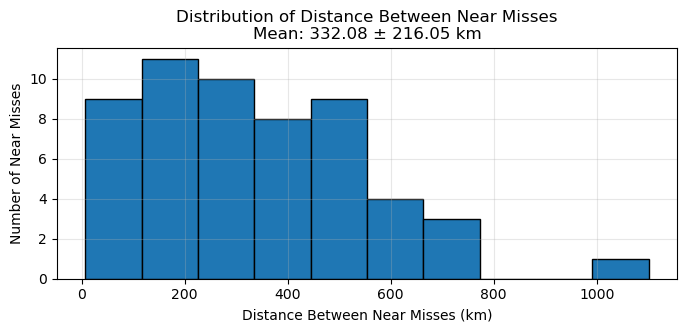

In [57]:
from haversine import haversine

# Get distances between near miss points
distances = [x[2] for x in intersections]
distances = [(x[0], x[1]) for x in distances] # Get lon,lat coordinates
distances = [haversine(p1, p2) for p1, p2 in zip(distances[:-1], distances[1:])]

plt.figure(figsize=(8, 3))
plt.hist(distances, bins=10, edgecolor='black')
plt.xlabel('Distance Between Near Misses (km)')
plt.ylabel('Number of Near Misses')
plt.title(f'Distribution of Distance Between Near Misses\nMean: {np.mean(distances):.2f} ± {np.std(distances):.2f} km')
plt.grid(True, alpha=0.3)
plt.show()


# Inspect Conflicts through Trajoscope 

In [47]:
from trajoscope import plot_trajectory

In [48]:
print(f'Analyzing intersection {intersections[6]}')

Analyzing intersection ('39b083ARL915  ', '48af0cLOT6394 ', (8.319999282026645, 42.7944820936307, 1718194182.6741886, 1718194172.7443829, 11521.44, 11262.36))


/Volumes/CrucialX/hlybokyi-potik/trajoscope.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_callsign['id'] = df_callsign['callsign'] + df_callsign['icao24']
/Volumes/CrucialX/hlybokyi-potik/trajoscope.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_callsign['id'] = df_callsign['callsign'] + df_callsign['icao24']


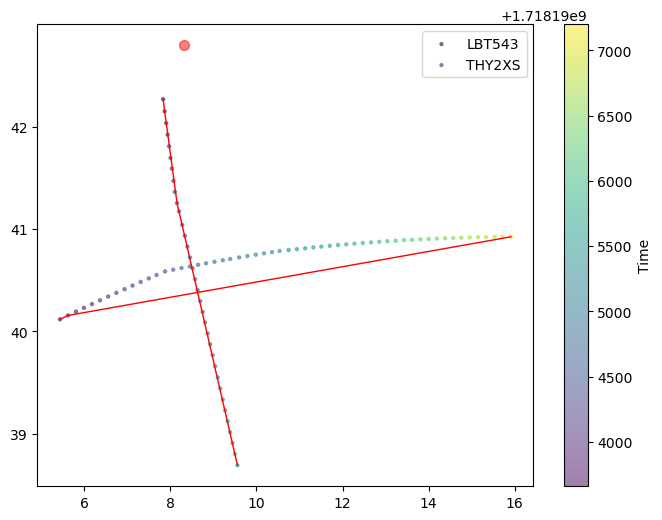

In [49]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(intersections[6][2][0], intersections[6][2][1], c='red', s=50, alpha=0.5)
plot_trajectory(1718193600, ['LBT543','THY2XS'], ax=ax, show_turn_overlay=True)
